<a href="https://colab.research.google.com/github/victorsobottka/bse-thesis-synthetic-data/blob/main/2_3_1_LLM_Fine_Tunning_Model_Trainning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🧪 Fine-Tunning Approach - Train the Model**

In [ ]:
# 🚀 Install dependencies
!pip install -q transformers peft accelerate datasets yfinance
!pip -q install -U bitsandbytes

In [ ]:
# Paso 2: Download NVIDIA stok closing prices from Yahoo Finance
import yfinance as yf
import pandas as pd
import numpy as np
import json

ticker = 'NVDA'
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
data.reset_index(inplace=True)
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
data = data[['Date', 'LogReturn']]

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [ ]:
print(data.head())

Price        Date LogReturn
Ticker                     
1      2020-01-03 -0.016136
2      2020-01-06  0.004185
3      2020-01-07  0.012034
4      2020-01-08  0.001874
5      2020-01-09  0.010923


In [ ]:
# Paso 3: Crear dataset .jsonl con series de 100 días
window = 100
samples = []

for i in range(len(data) - window):
    chunk = data.iloc[i:i+window]
    # Access Date by index 0 and LogReturn by index 1
    text = "\n".join([f"Date: {row[0].date()}, LogReturn: {row[1]:.4f}" for row in chunk.itertuples(index=False)]) # Use index=False to exclude the default index as the first element
    samples.append({"text": text})

with open("logreturn_dataset.jsonl", "w") as f:
    for s in samples:
        f.write(json.dumps(s) + "\n")


In [ ]:
# Paso 4: Cargar modelo base y preparar LoRA
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

model_id = "deepseek-ai/deepseek-llm-7b-base"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_4bit=True,
    torch_dtype=torch.float16,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [ ]:
# Paso 5: Aplicar LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [ ]:
# Paso 6: Tokenizar dataset y preparar para entrenamiento
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling
import pandas as pd
import json

# Cargar datos manualmente del archivo jsonl
samples = []
with open("logreturn_dataset.jsonl", "r") as f:
    for line in f:
        samples.append(json.loads(line))

# Convertir a DataFrame y luego a Dataset
data_df = pd.DataFrame(samples)
dataset = Dataset.from_pandas(data_df)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

In [ ]:
# Paso 7: Configurar entrenamiento
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./deepseek-logreturn",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


<ipython-input-8-1d6db3ec1836>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Paso 8: Entrenar modelo
trainer.train()

Step,Training Loss
10,0.377800
20,0.306800
30,0.300800
40,0.297800
50,0.300600
60,0.295800
70,0.296100
80,0.294300
90,0.293500
100,0.293800


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=339, training_loss=0.2355517384576938, metrics={'train_runtime': 3668.6837, 'train_samples_per_second': 0.74, 'train_steps_per_second': 0.092, 'total_flos': 5.403064648964506e+16, 'train_loss': 0.2355517384576938, 'epoch': 2.9812154696132596})

In [ ]:
# Save model in google drive
from google.colab import drive
drive.mount('/content/drive')

# Save the trained model to Google Drive
output_dir_drive = "/content/drive/MyDrive/deepseek-logreturn-finetuned"
trainer.save_model(output_dir_drive)
tokenizer.save_pretrained(output_dir_drive)

Mounted at /content/drive


('/content/drive/MyDrive/deepseek-logreturn-finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/deepseek-logreturn-finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/deepseek-logreturn-finetuned/tokenizer.json')

In [ ]:
# Paso 9: Generar log-returns sintéticos
prompt = """Generate synthetic log returns for NVIDIA starting from 2020-01-01:
Date: 2020-01-01, LogReturn:"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=3048, temperature=0.8)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

# Paso 10: Comparar distribución real vs generada
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Real
real_log_returns = data['LogReturn'].values

# Extraer valores generados del texto
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
import re
generated_values = [float(x) for x in re.findall(r"LogReturn:\s*(-?\d+\.\d+)", generated_text)]



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


Generate synthetic log returns for NVIDIA starting from 2020-01-01:
Date: 2020-01-01, LogReturn: -0.0080
Date: 2020-01-02, LogReturn: 0.0160
Date: 2020-01-03, LogReturn: 0.0144
Date: 2020-01-06, LogReturn: -0.0648
Date: 2020-01-07, LogReturn: 0.0661
Date: 2020-01-08, LogReturn: -0.0148
Date: 2020-01-09, LogReturn: 0.0462
Date: 2020-01-10, LogReturn: -0.0621
Date: 2020-01-13, LogReturn: 0.0306
Date: 2020-01-14, LogReturn: 0.0546
Date: 2020-01-15, LogReturn: -0.0179
Date: 2020-01-16, LogReturn: -0.0496
Date: 2020-01-17, LogReturn: -0.0467
Date: 2020-01-21, LogReturn: 0.0173
Date: 2020-01-22, LogReturn: 0.0121
Date: 2020-01-23, LogReturn: 0.0003
Date: 2020-01-24, LogReturn: -0.0760
Date: 2020-01-27, LogReturn: -0.0468
Date: 2020-01-28, LogReturn: -0.0156
Date: 2020-01-29, LogReturn: 0.0372
Date: 2020-01-30, LogReturn: 0.0067
Date: 2020-01-31, LogReturn: 0.2147
Date: 2020-02-03, LogReturn: -0.0320
Date: 2020-02-04, LogReturn: 0.0275
Date: 2020-02-05, LogReturn: 0.0141
Date: 2020-02-06, Log

In [ ]:
print(generated_values[:5])

[-0.008, 0.016, 0.0144, -0.0648, 0.0661]


In [ ]:
import pandas as pd
# Paso 11: Mostrar datos generados en una tabla

# Extract dates from the generated text
generated_dates = [d for d in re.findall(r"Date:\s*(\d{4}-\d{2}-\d{2})", generated_text)]

# Ensure the lengths of dates and values match
# If they don't match, it means the generated text format was unexpected
# For simplicity, we'll just use the minimum length to avoid errors
min_len = min(len(generated_dates), len(generated_values))
generated_dates = generated_dates[:min_len]
generated_values = generated_values[:min_len]


generated_df = pd.DataFrame({
    'Date': generated_dates,
    'Generated LogReturn': generated_values
})

print("\nGenerated Log Returns:")
from google.colab import data_table
data_table.enable_dataframe_formatter()
display(generated_df)



Generated Log Returns:


,Date,Generated LogReturn
0,2020-01-01,-0.0080
1,2020-01-02,0.0160
2,2020-01-03,0.0144
3,2020-01-06,-0.0648
4,2020-01-07,0.0661
...,...,...
117,2020-06-18,-0.0454
118,2020-06-19,0.0322
119,2020-06-22,-0.0356
120,2020-06-23,-0.0096


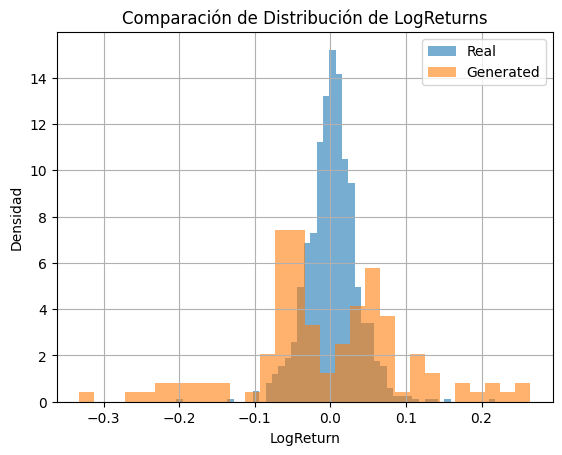

KS Test: Statistic = 0.2951, p-value = 0.0000


In [ ]:
# Plot comparsion
plt.hist(real_log_returns, bins=50, alpha=0.6, label='Real', density=True)
plt.hist(generated_values, bins=30, alpha=0.6, label='Generated', density=True)
plt.legend()
plt.title("Comparación de Distribución de LogReturns")
plt.xlabel("LogReturn")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# Test de Kolmogorov-Smirnov
stat, pval = ks_2samp(real_log_returns[:len(generated_values)], generated_values)
print(f"KS Test: Statistic = {stat:.4f}, p-value = {pval:.4f}")